# Argentina flights

In [179]:
import pandas as pd

df = pd.read_csv('ANAC-flights-2024.csv', skipinitialspace=True)

df.columns = df.columns.str.rstrip()

# Strip trailing spaces or tabs from all string values in the DataFrame
df = df.map(lambda x: x.rstrip() if isinstance(x, str) else x)

df.head()

,Fecha UTC,Hora UTC,Clase Vuelo,Clasificación,Tipo de Movimiento,Aeropuerto,Origen-Destino,Aerolinea,Aeronave,Pasajeros,PAX,Calidad dato
0,01/01/2024,0:02,Regular,Internacional,Aterrizaje,AER,SBGR,LATAM AIRLINES BRASIL (exTAM LA SA),0,145,145,DEFINITIVO
1,01/01/2024,0:02,Regular,Internacional,Aterrizaje,EZE,LFPG,AIR FRANCE,0,217,217,DEFINITIVO
2,01/01/2024,0:05,Regular,Internacional,Aterrizaje,EZE,LEMD,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,168,168,DEFINITIVO
3,01/01/2024,0:08,Regular,Internacional,Despegue,EZE,KJFK,AMERICAN AIRLINES INC.,0,272,272,DEFINITIVO
4,01/01/2024,0:10,Regular,Internacional,Despegue,AER,SCEL,LATAM AIRLINES GROUP S.A.(exLAN AIRLINE),0,92,92,DEFINITIVO


| Column Title             | Data Type              | Description                                                                                                           |
|--------------------------|------------------------|-----------------------------------------------------------------------------------------------------------------------|
| Date                     | ISO-8601 Date (date)   | Flight date in UTC.                                                                                                   |
| UTC Time                 | ISO-8601 Time (time)   | UTC Time (Coordinated Universal Time). When evaluating this data, consider that Argentina's official time is UTC -3.   |
| Flight Class (all flights)| Text (string)         | Categories of flights                                                                                                 |
| Flight Classification    | Text (string)          | Classification of flight type: Domestic or International                                                              |
| Type of Movement         | Text (string)          | Classification of the type of movement. A "Movement" is considered to be an operation, either landing or takeoff.      |
| Airport                  | Text (string)          | Airport name FAA code                                                                                                 |
| Origin/Destination       | Text (string)          | FAA code for domestic airports and ICAO code for foreign airports.                                                    |
| Airline Name             | Text (string)          | Name of the airline                                                                                                   |
| Aircraft                 | Text (string)          | Code to identify aircraft manufacturers with the specific model designation of the airplane.                          |
| Passengers               | Integer (integer)      | Number of passengers for an individual operation (takeoff/landing). For domestic flights, both takeoff and landing are recorded. When analyzing an individual airport, this column should be used. |
| PAX                      | Integer (integer)      | 1 pax = 1 boarding pass. Use this column when analyzing the total number of domestic passengers at the country level. For international passengers, either this column or the previous one can be used. |


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276325 entries, 0 to 276324
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Fecha UTC           276325 non-null  object
 1   Hora UTC            276325 non-null  object
 2   Clase Vuelo         276325 non-null  object
 3   Clasificación       276325 non-null  object
 4   Tipo de Movimiento  276325 non-null  object
 5   Aeropuerto          276325 non-null  object
 6   Origen-Destino      276325 non-null  object
 7   Aerolinea           276325 non-null  object
 8   Aeronave            276325 non-null  object
 9   Pasajeros           276325 non-null  int64 
 10  PAX                 276325 non-null  int64 
 11  Calidad dato        276325 non-null  object
dtypes: int64(2), object(10)
memory usage: 25.3+ MB


Drop invalid and useless data

In [181]:
df = df.drop(axis='index',
             labels=(df.loc[(df['Aeronave'] == '0') | (df['Aerolinea'] == '0') | (df['Pasajeros'] == 0)]).index)
df = df.drop(axis='columns', labels=['Calidad dato'])
df.shape

(134046, 11)

Refactor 

In [182]:
df['Fecha UTC'] = pd.to_datetime(df['Fecha UTC'], format='%d/%m/%Y')

# Get day of week
df['Día de la semana'] = df['Fecha UTC'].dt.dayofweek

# Discretizate hour of flight
df['Hora UTC'] = df['Hora UTC'].astype(str).str.strip() + ':00'
df['Hora UTC'] = pd.to_timedelta(df['Hora UTC'])
df['Hora UTC'] = df['Hora UTC'].dt.total_seconds() / 3600
df['Hora UTC'] = df['Hora UTC'].astype('int32')

# Discretizate month and day of month
df['Mes'] = df['Fecha UTC'].dt.month
df['Día del mes'] = df['Fecha UTC'].dt.day

df.drop(columns=['Fecha UTC', 'PAX'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134046 entries, 6 to 276324
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Hora UTC            134046 non-null  int32 
 1   Clase Vuelo         134046 non-null  object
 2   Clasificación       134046 non-null  object
 3   Tipo de Movimiento  134046 non-null  object
 4   Aeropuerto          134046 non-null  object
 5   Origen-Destino      134046 non-null  object
 6   Aerolinea           134046 non-null  object
 7   Aeronave            134046 non-null  object
 8   Pasajeros           134046 non-null  int64 
 9   PAX                 134046 non-null  int64 
 10  Día de la semana    134046 non-null  int32 
 11  Mes                 134046 non-null  int32 
 12  Día del mes         134046 non-null  int32 
dtypes: int32(4), int64(2), object(7)
memory usage: 12.3+ MB


In [183]:
num_cols = ['Hora UTC', 'Pasajeros']
cat_cols = [col for col in df.columns if col not in num_cols]

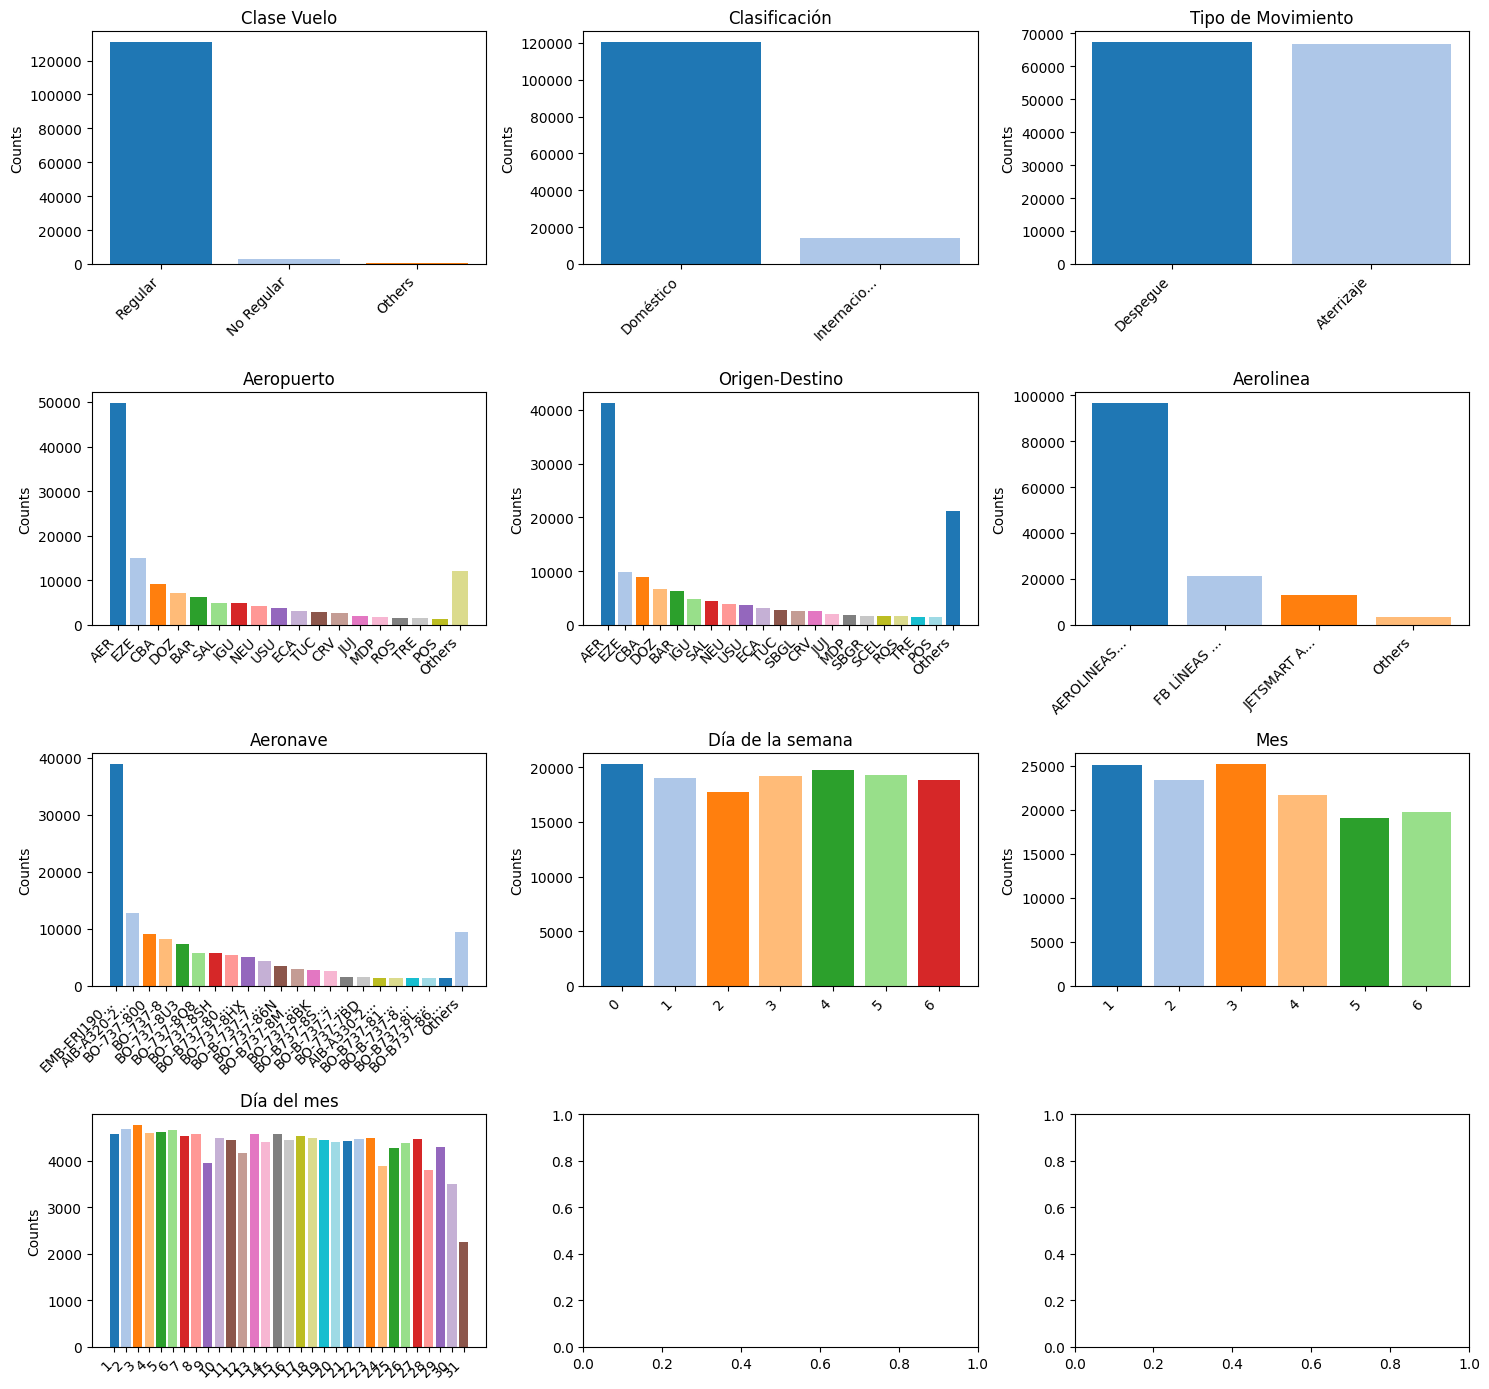

In [184]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 14))
ax = ax.flatten()

threshold =1
colors = plt.get_cmap('tab20').colors
max_label_length = 10

for i in range(len(cat_cols)):
    values = df[cat_cols[i]].value_counts()
    total = values.sum()
    percentages = (values / total) * 100
    
    above_threshold = values[percentages >= threshold]
    below_threshold = values[percentages < threshold]
    
    if below_threshold.size > 0:
        others = below_threshold.sum()
        above_threshold['Others'] = others

    labels = list(map(str, above_threshold.index))
    counts = above_threshold.values
    color_count = len(counts)
    
    if i > 6:
        numeric_labels = pd.to_numeric(above_threshold.index, errors='coerce')
        sorted_labels_series = pd.Series(numeric_labels, index=above_threshold.index).sort_values()
        sorted_indices = sorted_labels_series.index
        counts = above_threshold.loc[sorted_indices].values
        labels = sorted_indices.astype(str).tolist()

    truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in labels]

    ax[i].bar(range(len(labels)), counts, color=colors[:color_count])
    ax[i].set_title(cat_cols[i])
    ax[i].set_ylabel('Counts')
    
    ax[i].set_xticks(range(len(labels)))
    ax[i].set_xticklabels(truncated_labels, rotation=45, ha='right')

plt.subplots_adjust(hspace=0.4)

plt.tight_layout()
plt.show()


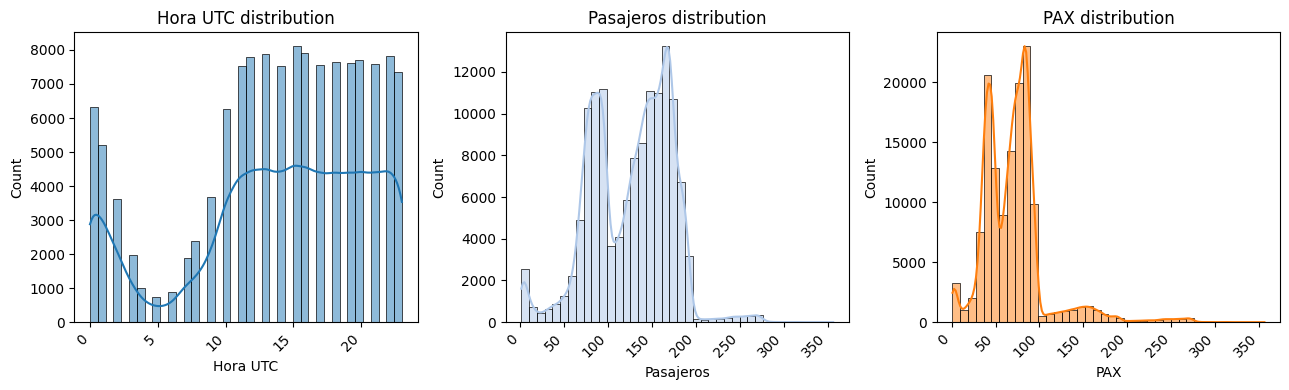

In [185]:
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))
ax = ax.flatten()

for i in range(len(num_cols)):
    sns.histplot(x=df[num_cols[i]], ax=ax[i], kde=True, color=colors[i], bins=40)
    ax[i].set_title(f'{num_cols[i]} distribution')
    
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()

## Passengers prediction

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the features (X) and the target (y)
X = df.drop(columns='Pasajeros')
y = df['Pasajeros']

num_features = [column for column in num_cols if column != 'Pasajeros']
cat_features = cat_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=1310
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [196]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [197]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R²: {r2:.4f}')
oob_score = rf.oob_score_
print(f"OOB Score: {oob_score:.4f}")


Root Mean Squared Error: 14.1464
R²: 0.9039
OOB Score: 0.9011


### Tuning hyperparameters with Cross-Validation

In [189]:
from sklearn.model_selection import GridSearchCV

hyperparams = {
    'regressor__n_estimators': [100, 200, 300, 400],
    'regressor__max_depth': [10, 15, 20, 25, 30, 35],
    'regressor__min_samples_split': [5, 10, 15, 20],
    'regressor__min_samples_leaf': [5, 10, 15, 20],
}


cv = GridSearchCV(estimator=model, param_grid=hyperparams, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

In [190]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   8.8s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   8.7s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=  10.5s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   9.9s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=  10.9s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=5, regressor__min_samples_split=5, regressor__n_estimators=200; total time=  24.6s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=5, r

/home/neville/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END regressor__max_depth=35, regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=100; total time= 1.1min
[CV] END regressor__max_depth=35, regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=100; total time= 1.0min
[CV] END regressor__max_depth=35, regressor__min_samples_leaf=5, regressor__min_samples_split=10, regressor__n_estimators=400; total time= 4.7min
[CV] END regressor__max_depth=35, regressor__min_samples_leaf=5, regressor__min_samples_split=10, regressor__n_estimators=400; total time= 4.5min
[CV] END regressor__max_depth=35, regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=100; total time= 1.1min
[CV] END regressor__max_depth=35, regressor__min_samples_leaf=5, regressor__min_samples_split=15, regressor__n_estimators=100; total time= 1.1min
[CV] END regressor__max_depth=35, regressor__min_samples_leaf=5, regressor__min_samples_split=10, regressor__n_estimators=40

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Hora '
                                                                          'UTC',
                                                                          'PAX']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Clase '
                                                                          'Vuelo',
                                                                          'Clasificación',
                                                                          'Tipo '
                                                                          'de '
                                                                          'Movimiento',
                                                                          'Aeropuerto',
                                                                          'Origen-Destino',
                                                                          'Aerolinea',
                                                                          'Aeronave',
                                                                          'Día '
                                                                          'de '
                                                                          'la '
                                                                          'semana',
                                                                          'Mes',
                                                                          'Día '
                                                                          'del '
                                                                          'mes'])])),
                                       ('regresso...
                                                              max_features='sqrt',
                                                              min_samples_leaf=5,
                                                              min_samples_split=10,
                                                              n_estimators=300,
                                                              n_jobs=-1,
                                                              oob_score=True,
                                                              random_state=1310))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [10, 15, 20, 25, 30, 35],
                         'regressor__min_samples_leaf': [5, 10, 15, 20],
                         'regressor__min_samples_split': [5, 10, 15, 20],
                         'regressor__n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_squared_error', verbose=2)

In [193]:
y_pred = cv.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.4f}')

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2:.4f}')

Mean Squared Error: 126.4948
Root Mean Squared Error: 11.2470
R² Score: 0.9392


The best Random Forest Regressor hyperparameters, chosen by the cross-validation model, are `max_depth=35`, `min_samples_leaf=5`, `min_samples_split=10`, and `n_estimators=400`. 

In [203]:
X_test_nat = X_test[X_test['Clasificación'] == 'Doméstico']
y_test_nat = y_test[X_test['Clasificación'] == 'Doméstico']

y_pred_nat = cv.predict(X_test_nat)

X_test_inter = X_test[X_test['Clasificación'] == 'Internacional']
y_test_inter = y_test[X_test['Clasificación'] == 'Internacional']

y_pred_inter = cv.predict(X_test_inter)

print(f'R² Score for National (Domestic) flights: {r2_score(y_test_nat, y_pred_nat):.4f}')
print(f'R² Score for International flights: {r2_score(y_test_inter, y_pred_inter):.4f}')

R² Score for National (Domestic) flights: 0.9488
R² Score for International flights: 0.8880


This is something really odd. We know, for the dataset columns information, that the PAX values of each row will be:
- if the flight is international, $passengers = PAX$
- if the flight is domestic, $passengers \neq PAX$ (specifically, $passengers = PAX + K$, where $K$ are the not domestic passengers at the total country level)  

We would expect the model to recognize the pattern where the target value is identical to one of the features under certain conditions. However, it failed to do so.  
Interestingly, the model performed significantly better in predicting the number of passengers for domestic flights. This is particularly valuable because, unlike the other case, this information is not already known.